# Group F Submission Notebook

In [1]:
import numpy as np
import pandas as pd
import random
import pickle
import ast

Parameters kept this way for testing purposes. For optimal results parameter configurations are as follow;

| Problem         | Runtime | N    | Ne   | Nm   | p    | a    | w    | Q          |
|-----------------|---------|------|------|------|------|------|------|------------|
| a280-n279       | 18000   | 500  | 0.3  | 0.2  | 0.8  | 0.3  | 50   | 25936      |
| a280-n1395      | 18000   | 1000 | 0.6  | 0.1  | 0.8  | 0.3  | 50   | 637010     |
| a280-n2790      | 18000   | 1000 | 0.6  | 0    | 0.5  | 0.3  | 50   | 1262022    |
|                 |         |      |      |      |      |      |      |            |
| fnl4460-n4460   | 10800   | 1000 | 0.6  | 0    | 0.5  | 0.2  | 50   | 387150     |
| fnl4460-n22300  | 10800   | 1000 | 0.6  | 0    | 0.5  | 0.1  | 50   | 10182055   |
| fnl4460-n44600  | 10800   | 1000 | 0.6  | 0    | 0.5  | 0.3  | 100  | 20244159   |
|                 |         |      |      |      |      |      |      |            |
| pla33810-n33809 | 10800   | 1000 | 0.6  | 0    | 0.6  | 0.1  | 50   | 1539600049 |
| pla33810-n169045| 5400    | 1000 | 0.3  | 0    | 0.8  | 0.3  | 1    | 77184794   |
| pla33810-n338090| 5400    | 1000 | 0.6  | 0    | 0.7  | 0.3  | 100  | 153960049  |

In [2]:
N = 500 #Population size
Q = 25936 #Capaciy of knap sack
Ne = int(0.3*(N)) #Number of elites
Nm = int(0.2*N) #Number of Mutants
prob = 0.8 #Probability of elites in bias crossovers
alpha = 0.3 #fraction of sample to generate
freq = 50 #Frequncy of local search
epoch = 18000 #Termination condition  

To test that our algorithm runs, we would use the test data but to see it's performance on the other datasets for this coursework, use the appropriate filenames in the cell below

| Name            | dataset_fl       | distance_fl                        | TSP_fl                                | KP_fl                              |
|-----------------|------------------|------------------------------------|---------------------------------------|------------------------------------|
| Test data       | a.csv            | distance_matrix                     | TSP_solutions                          | KP_Solutions                       |
| a280-n279       | a280-n279.csv    | distance_matrix_a280-n2790.pkl      | TSP_solutions_a280-n2790.txt          | a280-n279 KP_Solutions.txt         |
| a280-n1395      | a280-n1395.csv   | distance_matrix_a280-n2790.pkl      | TSP_solutions_a280-n2790.txt          | a280-n1395 KP_Solutions.txt        |
| a280-n2790      | a280-n2790.csv   | distance_matrix_a280-n2790.pkl      | TSP_solutions_a280-n2790.txt          | a280-n2790 KP_Solutions.txt        |
| fnl4461-n4460   | fnl4461-n4460.csv| distance_matrix_fnl4461-n4460.pkl   | TSP_solutions_fnl4461-n4460.txt       | fnl4461-n4460 KP_Solutions.txt     |
| fnl4461-n22300  | fnl4461-n22300.csv| distance_matrix_fnl4461-n4460.pkl  | TSP_solutions_fnl4461-n4460.txt       | fnl4461-n22300 KP_Solutions.txt    |
| fnl4461-n44600  | fnl4461-n44600.csv| distance_matrix_fnl4461-n4460.pkl  | TSP_solutions_fnl4461-n4460.txt       | fnl4461-n44600 KP_Solutions.txt    |


In [3]:
dataset_fl = './datasets/a280-n279.csv' #Filename of the input dataset
TSP_fl = './TSP Solutions/TSP_solutions_a280-n2790.txt' # TSP solutions file
KP_fl = './KP_Solutions/a280-n279 KP_Solutions.txt' # KP solutions file
distance_fl = './TSP Solutions/distance_matrix_a280-n2790.pkl' #Distance matix file

## Read the file

In [4]:
# write the code to read the data from csv files into df
df = pd.read_csv(dataset_fl)
# Transfer weights and profits into float numbers
for i in range(len(df['weights'])):
    w_list = df['weights'][i]
    str_list = w_list[1:-1].split(' ')
    new_w_list = [float(x) for x in str_list if x.strip()]
    df.at[i,'weights'] = new_w_list
for i in range(len(df['profit'])):
    p_list = df['profit'][i]
    str_list = p_list[1:-1].split(' ')
    new_p_list = [float(x) for x in str_list if x.strip()]
    df.at[i,'profit'] = new_p_list


## distance_matrix
with open(distance_fl,'rb') as file:
    distance_matrix = pickle.load(file)

TSP_solution = np.loadtxt(TSP_fl)


file_path = KP_fl

# Read the contents of the file
with open(file_path, 'r') as file:
    lines = file.readlines()
# Parse the contents to get the packing orders as a list of lists
KP_solution = [np.array([int(val) for val in ast.literal_eval(line.strip())]) for line in lines]
KP_solution = np.array(KP_solution)

In [5]:
# weights
weights_new = (df['weights'].tolist())
weights = [item[:] for item in weights_new if item]
weights = np.array(weights).flatten()

# profits
profit_new = (df['profit'].tolist())
profit = [item[:] for item in profit_new if item]
profit = np.array(profit).flatten()

In [6]:
#Write the fitness function
def get_fitness(solution, df, distances, Q, v_min=0.1, v_max=1):
    # Cost
    TSP_solution = solution['TSP']
    KP_solution = solution['KP']
    time = 0
    weights = df['weights']

    # calculate weight for each city
    KP_list = []
    idx = 0
    for i in range(len(weights)):
        w = weights[i]
        KP = KP_solution[idx:idx+len(w)]
        idx += len(w)
        KP_list.append(KP)

    # calculate speed
    speed = [(v_max - (np.sum(x) / Q) * (v_max - v_min)) if (v_max - (np.sum(x) / Q) * (v_max - v_min)) > 0.1 else 0.1 for x, weight in zip(KP_list, weights)]
    # calculate time
    n = len(TSP_solution)
    #print(n)
    for i in range(n-1):
        #print(distances[int(TSP_solution[i]),int(TSP_solution[i+1])])
        #print(distances[TSP_solution[i]][TSP_solution[i+1]])
        time += distances[int(TSP_solution[i]),int(TSP_solution[i+1])]/speed[i]
    time += distances[int(TSP_solution[n-1]),int(TSP_solution[0])]/speed[n-1]

    # Value
    profits = df['profit']
    v_list = []
    for w in profits:
        v_list.extend(w)
    item_value = pd.DataFrame({'z':KP_solution,'profit':v_list})
    item_value['value'] = item_value['z']*item_value['profit']
    value = -1 * np.sum(item_value['value'])

    # combine 2_opt
    solution['cost'] = np.array([time, value])
    return solution

In [7]:
#calculates the value/wieght ratio and stores in an array
def calculate_ratio(KP,values,weights):
    value_weight_ratio = np.array(values) / np.array(weights)
    value_weight_ratio = value_weight_ratio.flatten()
    result = [a * b for a, b in zip(KP, value_weight_ratio)]
    #print(result)
    return result

def find_highest_value_index(arr):
    max_value = max(arr)
    return arr.index(max_value)

"""#Fitness function, currently used as random
def fitness(pi,z):
    '''THIS NEEDS TO BE REMOVED'''
    return random.randint(1, 100)"""

'''
TSP_solutions = [[1,2,3,4],[1, 4, 3, 2], [1,3, 2, 4]]  # These are the TSP solutions
KP_solutions = [[1,0,1,1,0,1,0,0,1,1,0,0,1,0,1],[0,1,1,0,1,0,1,1,0,0,1,0,1,1,0]]
weights = [10,15,20,25,30,20,15,25,15,30,36, 21, 48, 14, 31]
values = [100,250,50,200,150,215, 178, 292, 134, 251,189, 204, 123, 278, 156]
'''

def initial_population(TSP_solutions,KP_solutions,N, weights,values, distances, Q, alpha=0.4):
    S = []
    n_cities = len(TSP_solution[0])
    n_bagsize = len(KP_solutions[0])
    #print(TSP_solutions)
    for tsp_sols in range(0,len(TSP_solutions)):
        #get the first TSP solution and reverse it
        pi1 = TSP_solutions[tsp_sols]
        pi2 = pi1[::-1]
        pi2 = np.concatenate([pi2[-1:], pi2[:-1]])
        for kp_sols in range(0,len(KP_solutions)):
            #get the first KP solution and create an empty one as well
            z1 = KP_solutions[kp_sols]
            z2= [0] * (len(z1))
            z2 = np.array(z2)

            #create two individuals and add it to S
            enc1 = {'TSP': pi1, 'KP':z2}
            enc2 = {'TSP': pi2, 'KP':z2}
            #S.append(enc1)
            #S.append(enc2)
            #find the indecis with value 1 in kp solution

            arr = calculate_ratio(z1,values,weights)
            #print(arr)

            length = sum(1 for value in arr if value > 0)
            #print(length)

            i=0
            while(i<length):
                #find the index with highest ratio and remove from arr
                max_index = find_highest_value_index(arr)
                #print(max_index)
                arr[max_index] = 0.0
                #print(arr)

                #add the highest ratio into Z2
                z2[max_index] = 1
                sol1 = {'TSP': pi1, 'KP':z2}
                sol2 = {'TSP': pi2, 'KP':z2}
                fitness1 = get_fitness(sol1,df, distances, Q)
                fitness2 = get_fitness(sol2,df, distances, Q)

                is_dominant = dominates(fitness1, fitness2)

                
                del fitness1['cost'], fitness2['cost']


                #find the elite solution and append in S
                if(is_dominant):
                    S.append(fitness1)
                else:
                    S.append(fitness2)

                i+=1

    #randomly generate alpha
    #alpha = random.uniform(0, 1) # 0.4
    #A = random.sample(S, int(alpha * N)) # 40
    A = np.random.choice(S, int(alpha*N))
    B = mutant_generator(N-int(alpha*N), n_cities, n_bagsize, False)
    
    P = np.append(A, B)

    return P #array of dictioaries with

## Kanny's Mutation Generator
'''def mutation(alpha,n,TSP_solutions,KP_solutions,):
    B = []
    for _ in range(int((1-alpha)*n)):
        tsp_component = random.choice(TSP_solutions)
        kp_component = random.choice(KP_solutions)
        flag = {'TSP': tsp_component, 'KP':np.array(kp_component)}
        B.append(flag)
    return B
'''

## Esosa's Mutant Generator
def mutant_generator(Nm, n_cities, n_knapsack, encode=False):
      '''Randomly generates Ne number of solutions where Nm is the number of mutants'''
      mut_sols = [None]*Nm
      for i in range(Nm):
            tour_sample_plan = np.arange(1, n_cities)
            np.random.shuffle(tour_sample_plan) # randomly shuffles inplace
            rand_knapsack = np.random.randint(2, size=n_knapsack) # randomly generates an array of 1s and 0s for size n_knapsack
            mut_sol = {'TSP': np.append(0,tour_sample_plan),
                       'KP': rand_knapsack}
            
            # encode phenotype of encode == True
            if encode:
                  mut_sol = encode_phenotype_to_genotype(mut_sol)

            # add mutant to list
            mut_sols[i] = mut_sol

      return np.array(mut_sols)

In [8]:
#Encoder
def encode_phenotype_to_genotype(solution):
    # Assuming the first city is the starting point and is not included in the genotype
    #print(solution)
    tour_phenotype = solution['TSP'][1:]  # Exclude the first city for TSP genotype

    packing_phenotype = solution['KP']

    # Generate random genotype values for TSP
    tour_genotype_values = sorted([round(random.random(), 8) for _ in range(len(tour_phenotype))])
    # Create a mapping of phenotype to genotype values based on the sorted order
    #tour_genotype = [tour_genotype_values[tour_phenotype.index(city)] for city in sorted(tour_phenotype)]
    tour_genotype = [tour_genotype_values[list(tour_phenotype).index(city)] for city in sorted(tour_phenotype)]

    

    # Encode the packing plan: Assign 0.6 if item is picked (1), random < 0.5 otherwise
    packing_genotype = [round(random.uniform(0.5, 1.0), 8) if item == 1 else round(random.uniform(0, 0.4999), 8) for item in packing_phenotype]
    

    return {'TSP': np.array(tour_genotype), 'KP': np.array(packing_genotype)}

# # Example usage
# solution = {
#     'TSP': [0, 2, 1, 3], 
#     'KP': [1, 0, 1, 0, 0, 0]  
# }

# # Encode the phenotype back into a genotype
# genotype = encode_phenotype_to_genotype(solution)

# print(genotype)

#Decoder
def decode_genotype_to_phenotype(solution):
    tour_genotype = solution['TSP']
    packing_genotype = solution['KP']

    cities = np.arange(1, len(tour_genotype)+1)

    # get argnindx that sort tour
    argidx = np.argsort(tour_genotype)
    tour_order = np.append([0], cities[argidx])


    # Decoding the tour
    #tour_order = [0] + sorted(range(1, len(tour_genotype) + 1), key=lambda i: tour_genotype[i-1])

    # Decoding the packing plan
    packing_plan = [1 if gen > 0.5 else 0 for gen in packing_genotype]

    # Output format is a single long list for the packing plan
    return {
        'TSP': tour_order,
        'KP': np.array(packing_plan)  # Single long list
    }
# Using the new input provided



#Repair operator
#Repair operator
def repair_operator(phenotype, weights, max_capacity):
    """
    Repairs the phenotype by removing items from the packing plan until it becomes feasible.
    Items are removed city by city, starting from the first city visited.

    :param phenotype: The phenotype representation of the packing plan and tour.
    :param weights: List of weights for each item.
    :param max_capacity: The maximum capacity of the knapsack.
    :return: The repaired phenotype.
    """
    tour_order = phenotype['TSP'][1:]
    #packing_plan = phenotype['KP']
    fixed_bag = phenotype['KP'].copy()

    for i in tour_order:
        if np.sum(fixed_bag*weights) > max_capacity:
            flip_idx = int(len(fixed_bag)/len(tour_order)) # gets the number of items in each city. They're equal
            ### st = i*flip_idx  removed this because it started at the last item in the city instead of the first
            st = i*flip_idx - flip_idx # get's the idx which refers to the first item in city i
            # flip portion of bag to 0
            for j in range(st, st+flip_idx):
                #print(j)
                fixed_bag[j] = 0
        else:
            break

    return {'TSP': phenotype['TSP'], 'KP': fixed_bag}

In [9]:
# NSGA2
def dominates(p, q):
      """Checks if p dominates q"""
      return all(p['cost'] <= q['cost']) and any(p['cost'] < q['cost'])

def list_to_DF(population):
      '''
      Receives the entire list of solutions and converts it to a dataframe for NSGA2 to update rank and crowding distance
      Each solution is a dictionary e.g. {'TSP':[], 'KP':[], 'cost': [dist,prof]} and we need to have a 'rank' column which
      defines which front the solution belongs to and also a 'crowding_distance' column for crowding distance of each solution
      '''
      N = len(population)
      pop_df = pd.DataFrame({'TSP':[None]*N, 'KP':None, 'cost':None})

      for i in range(N):
            pop_df['TSP'][i] = population[i]['TSP']
            pop_df['KP'][i] = population[i]['KP']
            pop_df['cost'][i] = population[i]['cost']

      # this gave me issues
      #pop_df = pd.DataFrame(population)

      # add new columns
      pop_df['rank'] = None
      pop_df['crowding_distance'] = None

      return pop_df

def norm_objective(population_df):
      '''
      Normalizes the objectives before getting non-dom fronts and calculating crowding distance
      Refernce: https://link.springer.com/article/10.1007/s40747-017-0061-9
      '''

      population_df['fitness'] = population_df['cost']
      # Create 'traveltime' and 'profit' columns by extracting values from the 'cost' column
      population_df[['traveltime', 'profit']] = pd.DataFrame(population_df['cost'].tolist(), index=population_df.index)

      # Normalize 'traveltime' and 'profit'
      population_df['traveltime'] = (population_df['traveltime'] - population_df['traveltime'].min()) / (population_df['traveltime'].max() - population_df['traveltime'].min())
      population_df['profit'] = (population_df['profit'] - population_df['profit'].min()) / (population_df['profit'].max() - population_df['profit'].min())

      # Update the 'cost' column with the normalized values
      population_df['cost'] = population_df.apply(lambda row: np.array([row['traveltime'], row['profit']]), axis=1)

      # Drop the 'traveltime' and 'profit' columns
      population_df.drop(['traveltime', 'profit'], axis=1, inplace=True)

      return population_df

def df_to_list(population):
      '''
      Receives a list with columns TSP, KP, cost, rank and crowding distance, drops all except TSP and KP and returns a list of dictionaries where
      each dictionary represents a row in the dataframe
      '''
      popl = population[['TSP', 'KP']]

      # convert popl to a dictionary of dictionaries
      dofd = popl.to_dict(orient='index')
      # converts the dofd into a list of dictionaries
      lofd = [{**v} for k, v in dofd.items()]

      return lofd

def non_dominated_sorting(pop_df):
      """
      Perform Non-dominated Sorting on a Population where pop refers to the population dataframe
      Each row represents a solution and the columns are TSP, KP, cost, rank and crowding distance
      # check out column for the rank of each solution??
      """
      pop_size = len(pop_df) # gets the number of solution

      # Initialize Domination Stats
      domination_set = [[] for _ in range(pop_size)] # identifies the solutions that each solution dominates. Just stores and empty list for now
      dominated_count = [0 for _ in range(pop_size)] # how many solutions dominate each solution

      # Initialize Pareto Fronts <non-dominated fronts>
      F = [[]]

      # Find the first Pareto Front
      for i in range(pop_size):
            for j in range(i+1, pop_size):
                  # Check if i dominates j
                  if dominates(pop_df.loc[i], pop_df.loc[j]):
                        #if dominates(pop[i], pop[j]):
                        domination_set[i].append(j) # if i dom j, then add j to its domination list
                        dominated_count[j] += 1 # add 1 to the number of solutions that dominate j

                  # Check if j dominates i
                  elif dominates(pop_df.loc[j], pop_df.loc[i]):
                        #elif dominates(pop[j], pop[i]):
                        domination_set[j].append(i)
                        dominated_count[i] += 1

            # If i is not dominated at all
            if dominated_count[i] == 0:
                  pop_df.loc[i,'rank'] = 0
                  #pop[i]['rank'] = 0
                  F[0].append(i) # add to Pareto optimal front

      # Pareto Counter
      k = 0

      while True:

            # Initialize the next Pareto front
            Q = []

            # Find the members of the next Pareto front
            for i in F[k]: # for every solution in the curr front
                  for j in domination_set[i]: # look at the set of those that dominate it
                        dominated_count[j] -= 1 # subtract the members of the previous front from that list
                        if dominated_count[j] == 0: # if there's none
                              pop_df.loc[j,'rank'] = k + 1
                              #pop[j]['rank'] = k + 1
                              Q.append(j) # add solutiont to the next front

            # Check if the next Pareto front is empty
            if not Q:
                  break

            # Append the next Pareto front
            F.append(Q)

            # Increment the Pareto counter
            k += 1
      # return pop_df with ranks updated and also the Fronts, F
      return pop_df, F


def calc_crowding_distance(pop_df, F):
      """Calculate the crowding distance for a given population with the Fronts"""

      # Number of Pareto fronts (ranks)
      pareto_count = len(F)

      # Number of Objective Functions
      n_obj = len(pop_df.loc[0, 'cost'])

      # Iterate over Pareto fronts
      for k in range(pareto_count):
            # get all the costs for the elements in the Pareto front. Results in a matrix of size pareto_count x n_obj
            costs = np.array([pop_df.loc[i,'cost'] for i in F[k]])
            n = len(F[k]) # number of members in k-th front
            d = np.zeros((n, n_obj)) # creates a zero matrix of same shape as costs to store crowding distance

            # Iterate over objectives, column by column
            for j in range(n_obj):
                  idx = np.argsort(costs[:, j]) # for the jth obj, get the idx which sorts it. You're basically looking for the boundary solutions
                  # assign boundary solutions a distance = infinity
                  d[idx[0], j] = np.inf  # first
                  d[idx[-1], j] = np.inf # last

                  # iterate through the remaining values excluding the bounday solutions
                  for i in range(1, n-1):
                        # either calculates Euclidean distance or Manhattan to gauge distance
                        d[idx[i], j] = costs[idx[i+1], j] - costs[idx[i-1], j]
                        d[idx[i], j] /= costs[idx[-1], j] - costs[idx[0], j]

            # Calculate Crowding Distance
            for i in range(n):
                  pop_df.loc[F[k][i], 'crowding_distance'] = sum(d[i, :]) 
                  #pop_df[F[k][i]]['crowding_distance'] = sum(d[i, :]) # assigns crowding distance based on elements in each front

      return pop_df

def sort_population(pop):
      '''Sorts a population based on rank (in ascending order) and crowding distance (in descending order) to give us our best solutions'''
      pop.sort_values(by=['rank', 'crowding_distance'], ascending=[True, False], inplace=True)
      # pop = sorted(pop, key = lambda x: (x['rank'], -x['crowding_distance']))

      # max_rank = pop[-1]['rank']
      # F = []
      # for r in range(max_rank + 1):
      #       F.append([i for i in range(len(pop)) if pop[i]['rank'] == r])

      return pop #, F

def elite_nonelite_sepr(pop_df, n_elites):
      '''Divides pop_df into a list of elites and non-elites. Where n_elites is the number of elites that we want'''

      # since pop_df is already sorted we can just index the first n_elites-th solutions from the df
      elites_df = pop_df[:n_elites]
      non_elites_df = pop_df[n_elites:]

      # convert dfs to lists
      elites_L = df_to_list(elites_df)
      non_elites_L = df_to_list(non_elites_df)

      return elites_L, non_elites_L

In [10]:
# Local Search - Exploitation Phase
def local_Search(P_e, W, df, Q, distances, n_of_Ne=0.1):
      '''
      Performs the local search aspect of the algorithm on a subset of the elite population.
         Parameters:
            P_e: current elite population
            W: Weight of items in each city
            df: unknown?? Need to be confirmed from Xiao
            Q: Total weight constraint for the knapsack
            n_of_Ne: How many of the elite population do we want. Default=0.1
         Returns:
            P_e with added modified elites

      '''
      # get subset of elites that we would exploit to make better
      n_Pe_hat = round(n_of_Ne*len(P_e))
      Pe_hat = np.random.choice(P_e,n_Pe_hat)

      for elite in Pe_hat:
            # perform 2-opt local search on the TSP aspect
            elite = two_opt(elite, df, distances, Q)

            # perform bitflip on the KP aspect
            elite, P_e = bitflip_exploit(elite, W, Q, P_e, df, distances)

      return P_e #only because it contains all the exploited elites

def bitflip_exploit(soln, W, Q, P_e, df, distances):
      '''
      Performs bit-flip given a solution for about min(100,m) moves
      where m is the number of items.
      Solution format: soln = {'TSP':[], 'KP':[], 'cost': [dist,prof]}
      W is the weight and I'm using it's the same length as sol['KP']
      '''
      route = soln['TSP']
      knapsack = soln['KP']
      m = len(knapsack)
      count = 0

      # convert knapsack and W arrs to np.arrays
      if ~isinstance(knapsack,np.ndarray):
            knapsack = np.array(knapsack)
      if ~isinstance(W,np.ndarray):
            W = np.array(W)

      # create idx values for knapsack
      idx_kp = np.arange(len(knapsack))
      max_iteration = min(100, m) if m < 100 else 100 
      new_sol = {'TSP':route, 'KP':knapsack}

      while count < max_iteration:
            #print("Iteration num for bitflip_exploit: %s" % count)
            count += 1
            # randomly select an idx to flip
            idx = np.random.choice(idx_kp, 1)[0]
            # delete select idx from selection pool
            idx_kp = idx_kp[~(idx_kp==idx)]

            # create copy of knapsack
            kp_temp = knapsack.copy()
            # run bit flip at idx
            if kp_temp[idx]: # true if value at idx is 1
                  kp_temp[idx] = 0
            else:
                  kp_temp[idx] = 1

            # check if weight constraints is broken
            kp_temp_weights = kp_temp * W # only gets the weights of the items in the knapsack. Those that aren't are given the value of 0
            if np.sum(kp_temp_weights) > Q:
                  continue
            else:
                  # assign new kp order to knapsack
                  knapsack = kp_temp

            # get cost of new solution
            new_sol = {'TSP':route, 'KP':knapsack}
            new_sol = get_fitness(new_sol, df, distances, Q) # Function from Xiao and it return solution + cost

            # check if solution is not dominated by any member of Pe
            dom = False # flag for if new solution is dominated
            for elite_sol in P_e:
                  if dominates(elite_sol, new_sol):
                        dom = True
                        continue

            if dom == False:
                  # add solution to elites if it is non-dom
                  P_e = np.concatenate([P_e, [new_sol]])

      return new_sol, P_e




def two_opt(soln, df, distances, Q):
      '''
      Performs 2-opt Local Search given a solution for about min(100,n^3) moves
      where n is the number of cities.
      Solution format: soln = {'TSP':[], 'KP':[], 'cost': [dist,prof]}

      df and distance need to be confirmed from Xiao
      '''
      n = len(soln) # number of cities
      knapsack = soln['KP']
      sol_to_beat = soln  # Store initial solution
      route_to_beat = sol_to_beat['TSP'].copy()  # copy the initial route `tour based on what I'm getting from other functions``

      #start_time = time.time()
      improved = True # flag to indicate if solution has improved
      # max_iterations = min(2, n ** 3) if n < 2 else 2
      max_iterations = min(100, n ** 3) if n < 100 else 100 
      count = 0
      # iter = 0
        
      while improved and (count < max_iterations):
            #print("Iteration num for two_opt: %s" % count)
            #count += 1
            improved = False # Reset improved flag for each iteration

            # iterate through each pair of edges in the route
            # it automatically skips the first one since that city needs to stay the same
            for i in range(1, len(route_to_beat) - 2):  # Time Complexity: O(n)
                  for j in range(i + 1, len(route_to_beat)):
                        if j - i == 1:
                              # skip neighbouring cities e.g., (1,2) or (4,5)
                              continue
                        count += 1
                        # apply 2-opt swap to generate a new route
                        new_route = route_to_beat.copy()  # Space Complexity: O(n)
                        new_route[i:j] = route_to_beat[j - 1:i - 1:-1]

                        # calculates fitness of new solution
                        new_sol = {'TSP':new_route, 'KP':knapsack}
                        new_sol = get_fitness(new_sol, df, distances, Q) # this gets the cost for this solution
                        
                        # update old solution if it is not better than the new
                        if ~dominates(sol_to_beat, new_sol):
                              sol_to_beat = new_sol
                              route_to_beat = new_route
                              improved = True # set flag to indicate improvement
                        
                        if ~(count < max_iterations):
                              break
                        

      #end_time = time.time()

      #results = {'cost': sol_to_beat.cost, 'time': end_time - start_time, 'count': count, 'soln': sol_to_beat,
      #            'max': None, 'total': None, 'pruned': None}

      # return the best solution seen
      return sol_to_beat

In [11]:
# Biased Crossover
def biased_crossover(solution1, solution2, prob=0.5):
    KP1 = solution1['KP']
    KP2 = solution2['KP']
    TSP1 = solution1['TSP']
    TSP2 = solution2['TSP']
#   KP_likelihood = np.random.rand(len(KP_solution1))
#   TSP_likelihood = np.random.rand(len(TSP_solution1))
    KP_likelihood = np.random.rand(len(KP1))
    TSP_likelihood = np.random.rand(len(TSP1))
    cross_KP = np.array([KP1[i] if KP_likelihood[i]>prob else KP2[i] for i in range(len(KP1))])
    cross_TSP = np.array([TSP1[i] if TSP_likelihood[i]>prob else TSP2[i] for i in range(len(TSP2))])
    crossed_solution = {'TSP':cross_TSP, 'KP':cross_KP}
    return crossed_solution


## Initialise Population

In [12]:
population  = initial_population(TSP_solution,KP_solution,N, weights,profit, distance_matrix, Q, alpha)

In [13]:
len(population)

500

In [14]:
# lists to contain encoded solutions for elites and non-elites
elites_enco = []
nonelites_enco = []
fitness_per_iteration = []

ti = 0 # Iteration counter

while(ti<epoch):
    #when ti=0, only calculate the fitness, perform non-dominated sorting to get elites and non-elites 
    if(ti==0):
        # calculate the fitness of each solution on both objectives and add new key-value pair called 'cost'
        for solution in population:
              solution = get_fitness(solution, df, distance_matrix, Q)
       
        ### survival ###
        
        #converting to dataframe
        dec_pop_DF = list_to_DF(population)
        
        # normalize objectives
        # it's now a min-min problem
        dec_pop_DF = norm_objective(dec_pop_DF)  
        
        # non-dominated sorting
        dec_pop_DF, pareto_fronts = non_dominated_sorting(dec_pop_DF)
        dec_pop_DF = calc_crowding_distance(dec_pop_DF, pareto_fronts)
        
        # sort population from best to worst
        dec_pop_DF = sort_population(dec_pop_DF)
        
        # add fitness to list
        fitness_per_iteration.append(dec_pop_DF['fitness'][0])
        
        # divide into elites and non-elits
        elites, nonelites = elite_nonelite_sepr(dec_pop_DF, Ne)
        print(ti)
        
    
    else:
        # lists to contain encoded solutions for elites and non-elites
        elites_enco = []
        nonelites_enco = []
        
        #Encode Elites and Non-Elites
        for solution in elites:
            elites_enco.append(encode_phenotype_to_genotype(solution))
        
        for solution in nonelites:
            nonelites_enco.append(encode_phenotype_to_genotype(solution))
        
        ## Genetic Operators: Biased CRSV and Mutant Generator ##
        
        # populate empty list for crossover offspring
        crsv_offspring = np.array([None]*(N-Ne-Nm))
        
        
        #Perform crossover over N-Ne-Nm elements
        for i in range(N-Ne-Nm):
            solution1_elite = np.random.choice(elites_enco, 1)[0]
            solution2_any = np.random.choice(np.append(elites_enco, nonelites_enco), 1)[0]
            
            
            crsv_result = biased_crossover(solution1_elite, solution2_any, prob)
            crsv_offspring[i] = crsv_result
        
        
        #Mutant Generator
        n_cities = len(nonelites_enco[0]['TSP'])+1
        n_knapsack = len(nonelites_enco[0]['KP'])
        mutant_offspring = mutant_generator(Nm, n_cities, n_knapsack, True)
        
        #### constructing the next population ####
        
        # select as subset of Ne from the elites
        elites_enco = random.sample(elites_enco, Ne)

        # let the non_elites be our genetic offsprings
        nonelites_enco = np.append(crsv_offspring, mutant_offspring)
        
        #### Decode & Repair ####
        
        # decode encoded elites
        elites_dec = np.array([None] * len(elites_enco))
        

        for i in range(len(elites_enco)):
            temp = decode_genotype_to_phenotype(elites_enco[i])
            elites_dec[i] = temp
            
        # decode encoded non-elites
        nonelites_dec = np.array([None] * len(nonelites_enco))

        for i in range(len(nonelites_enco)):
            temp = decode_genotype_to_phenotype(nonelites_enco[i])
            nonelites_dec[i] = temp
        
        # gets the solutions that violate max weight constraint
        bad_list = []
        for idx in range(len(nonelites_dec)):
            if np.sum(nonelites_dec[idx]['KP']*weights) > Q:
                bad_list.append(idx)
        
        # separate the good from the bad
        bad_solutions = nonelites_dec[bad_list]
        nonelites_dec = np.delete(nonelites_dec, bad_list)
        
        # repair the bad lists
        repaired_solutions = []
        for solution in bad_solutions:
            repaired_sol = repair_operator(solution, weights, Q)
            repaired_solutions.append(repaired_sol)

        repaired_solutions = np.array(repaired_solutions)
        
        # delete bad solutions and append repaired to the nonelites_dec
        del bad_solutions
        nonelites_dec = np.append(nonelites_dec, repaired_solutions)
        
        #### Fitness Evaluation ####

        # calculate the fitness of each solution on both objectives and add new key-value pair
        for solution in nonelites_dec:
              solution = get_fitness(solution, df, distance_matrix, Q)
        for solution in elites_dec:
              solution = get_fitness(solution, df, distance_matrix, Q)
        
        #after every freq performs 2-opt local search on the TSP and bit-flip on the KP and checks 
        #for overall improvement in fitness
        
        if(ti%freq == 0):
            elites_dec = local_Search(elites_dec, weights, df, Q, distance_matrix)
        
        #### Survival ####
        # we can combine our 2 lists together for it to be resorted
        dec_pop = np.append(elites_dec, nonelites_dec)
        
        # convert to DF for easier fronts calculation 
        dec_pop_DF = list_to_DF(dec_pop)
        
        # normalize objectives
        # it's now a min-min problem
        dec_pop_DF = norm_objective(dec_pop_DF)
        
        # non-dominated sorting
        dec_pop_DF, pareto_fronts = non_dominated_sorting(dec_pop_DF)
        dec_pop_DF = calc_crowding_distance(dec_pop_DF, pareto_fronts)
        
        # sort population from best to worst
        dec_pop_DF = sort_population(dec_pop_DF)
        
        # add fitness to list
        fitness_per_iteration.append(dec_pop_DF['fitness'][0])
        
        # divide into elites and non-elits
        elites, nonelites = elite_nonelite_sepr(dec_pop_DF, Ne)
        print(ti)
         

    ti+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\LEGION\AppData\Local\Temp\ipykernel_18848\770429394.py:158: RuntimeWarning: invalid value encountered in scalar divide
  d[idx[i], j] /= costs[idx[-1], j] - costs[idx[0], j]


2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749


In [15]:
dec_pop_DF

,TSP,KP,cost,rank,crowding_distance,fitness
32,"[0, 20, 253, 123, 45, 221, 135, 228, 12, 232, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0.9200241031709698, 0.0]",0,inf,"[34140.71937876104, -206444.0]"
44,"[0, 8, 6, 7, 9, 202, 160, 189, 203, 211, 214, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.0, 0.9411934431941291]",0,inf,"[10601.841380878195, -33559.0]"
73,"[0, 8, 6, 7, 9, 202, 160, 189, 203, 211, 214, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.0, 0.9411934431941291]",0,inf,"[10601.841380878195, -33559.0]"
91,"[0, 3, 8, 6, 7, 9, 202, 160, 189, 203, 211, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.012787469195454934, 0.4456766129339583]",0,1.255839,"[10929.009632509928, -124579.0]"
3,"[0, 54, 29, 148, 40, 252, 183, 162, 249, 138, ...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...","[0.8127141194022285, 0.1281201173735757]",0,1.227157,"[31395.18629198517, -182910.0]"
...,...,...,...,...,...,...
469,"[0, 82, 62, 262, 103, 214, 114, 193, 171, 246,...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.9743883218733084, 0.9645048370325608]",103,inf,"[35531.6315375556, -29277.0]"
354,"[0, 202, 115, 33, 6, 138, 243, 263, 69, 70, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9504597845809474, 0.9715820934524491]",103,1.372502,"[34919.41831612872, -27977.0]"
188,"[0, 12, 202, 65, 236, 160, 164, 150, 211, 91, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.9660826774669946, 0.9714187721504516]",103,1.133281,"[35319.13107186108, -28007.0]"
452,"[0, 131, 212, 213, 109, 169, 206, 38, 162, 234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.9765961853545476, 0.9745001007148029]",104,inf,"[35588.11987187396, -27441.0]"


In [22]:
dec_pop_DF.to_csv('ResultDF.csv', sep=';', index=False,header=True)
np.save('fitness_per_iteration.npy', fitness_per_iteration)

In [5]:
np.array(pd.read_csv('ResultDF.csv', sep=';').iloc[0,0])

array('[  0  20 253 123  45 221 135 228  12 232  87  14  78  40 244 252 101 158\n  10  97  44  54 136 275  25 200  48  59 116  24  57  17 210 132 205  28\n 100  53 250 246 189  19 108  67  64  55 257 117  92 148 240  58 263 106\n   1  72  68 143  46 149 208 184 122  26  16 114 170 260  82 234 168 163\n 227 181 102 238 214 174 201 172 128 180   8  56 194 231 125 237  27   9\n 176  65  13 134   4 277 171   3 154  85 243 190 103  60 278  37 112 127\n 235 219  41  88 207 236 209  34  76  75  52 109  62 258 113 160 186  29\n 242  86  39  50 199 273 204 251 120 175 173 198 202 197 217 152  36  18\n 220 153 177 187 225 147 178 146 271  30  84 247 162 130  21 188 264 107\n 141 110 192 121 185  74 259  61 156  33  22 196 142   6  15 105 144  63\n  90  42  73 161  83 262 245 104  99  94 211  69 230 138  23 118 226 279\n  95 223 145 179 224 222 203 111 183 124  49 191 274 266 254 270 248 167\n  32 150 157   5  93 164 267 133 115 193  31  81  35 268 241  38  71 119\n  96  43 212 272 195  89 276 18

In [2]:
# Given string representing an array
string_array = pd.read_csv('ResultDF.csv', delimiter=';').iloc[0,0]

# Removing unnecessary characters
string_array_cleaned = string_array.replace('[', '').replace(']', '').replace('\n', '')

# Convert the string to a NumPy array
np_array = np.fromstring(string_array_cleaned, sep=' ', dtype=np.int64)

In [3]:
# Read the CSV file with ';' as the delimiter and custom converters
def convert_to_array_int(x):
      try:
            string_arr_cleaned = x.replace('[', '').replace(']', '').replace('\n', '')
            np_arr = np.fromstring(string_arr_cleaned, sep=' ', dtype=np.int64)
            
            return np_arr
      except ValueError or SyntaxError:
            return x

def convert_to_array_float(x):
      try:
            string_arr_cleaned = x.replace('[', '').replace(']', '').replace('\n', '')
            np_arr = np.fromstring(string_arr_cleaned, sep=' ')

            return np_arr
      except ValueError or SyntaxError:
            return x

converters = {
    'TSP': convert_to_array_int,
    'KP': convert_to_array_int,
    'cost': convert_to_array_float,
    'fitness': convert_to_array_float
}

In [4]:
# Read the CSV file using the custom converters
dec_pop_DF = pd.read_csv('ResultDF.csv', delimiter=';', converters=converters)

fitness_per_iteration = np.load('fitness_per_iteration.npy')

In [5]:
dec_pop_DF['KP']

0      [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...
1      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
2      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4      [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...
                             ...                        
495    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
496    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
497    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
498    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
499    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
Name: KP, Length: 500, dtype: object

In [6]:
x1=[]
y1=[]

for i in dec_pop_DF['fitness']:
    x1.append(i[0])
    y1.append(i[1])

In [7]:
import matplotlib.pyplot as plt

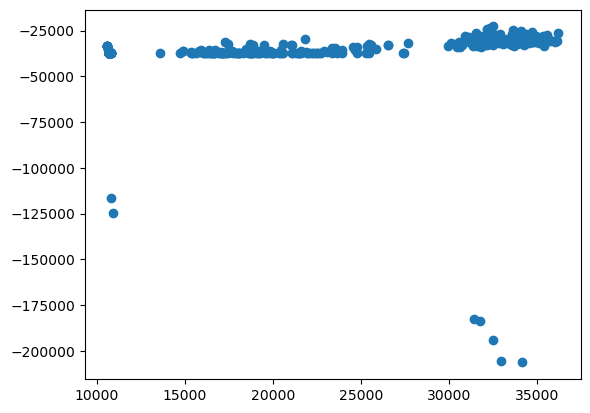

In [8]:
plt.scatter(x1, y1)

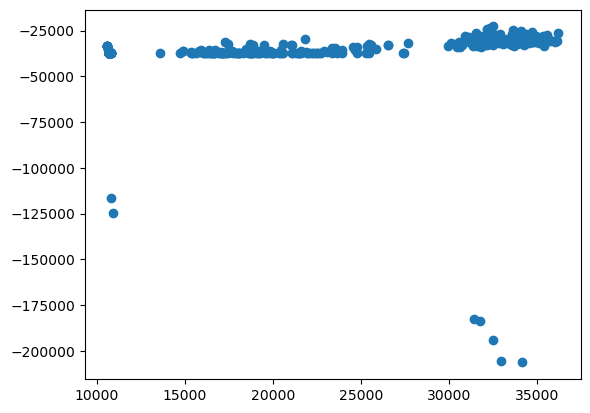

In [9]:
plt.scatter(x1, y1)

Text(0, 0.5, 'Profit of Knapsack')

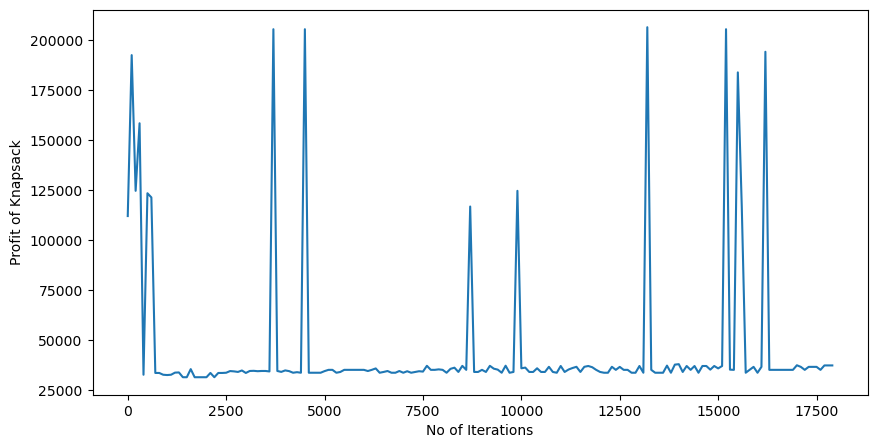

In [10]:
plt.figure(figsize=(10,5))
plt.plot(-pd.DataFrame(fitness_per_iteration)[1][::100])
plt.xlabel('No of Iterations')
plt.ylabel('Profit of Knapsack')

Text(0, 0.5, 'Time of tour')

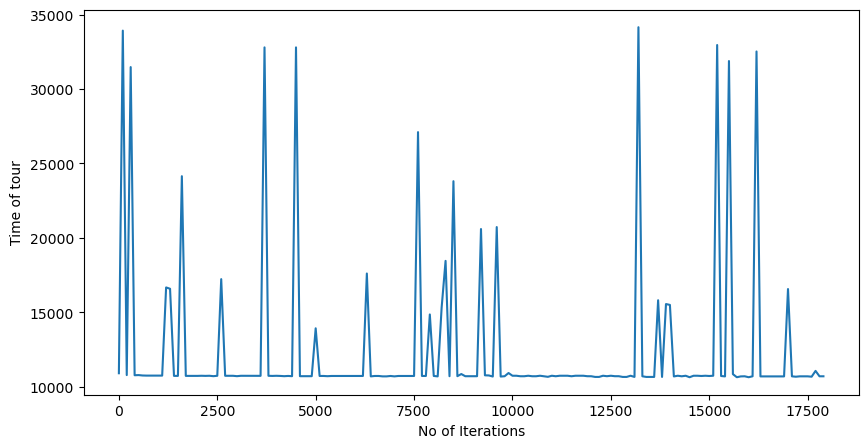

In [11]:
plt.figure(figsize=(10,5))
plt.plot(pd.DataFrame(fitness_per_iteration)[0][::100])
plt.xlabel('No of Iterations')
plt.ylabel('Time of tour')

In [12]:
dec_pop_DF

,TSP,KP,cost,rank,crowding_distance,fitness
0,"[0, 20, 253, 123, 45, 221, 135, 228, 12, 232, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0.9200241, 0.0]",0,inf,"[34140.71937876, -206444.0]"
1,"[0, 8, 6, 7, 9, 202, 160, 189, 203, 211, 214, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.0, 0.94119344]",0,inf,"[10601.84138088, -33559.0]"
2,"[0, 8, 6, 7, 9, 202, 160, 189, 203, 211, 214, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.0, 0.94119344]",0,inf,"[10601.84138088, -33559.0]"
3,"[0, 3, 8, 6, 7, 9, 202, 160, 189, 203, 211, 21...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.01278747, 0.44567661]",0,1.255839,"[10929.00963251, -124579.0]"
4,"[0, 54, 29, 148, 40, 252, 183, 162, 249, 138, ...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...","[0.81271412, 0.12812012]",0,1.227157,"[31395.18629199, -182910.0]"
...,...,...,...,...,...,...
495,"[0, 82, 62, 262, 103, 214, 114, 193, 171, 246,...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.97438832, 0.96450484]",103,inf,"[35531.63153756, -29277.0]"
496,"[0, 202, 115, 33, 6, 138, 243, 263, 69, 70, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.95045978, 0.97158209]",103,1.372502,"[34919.41831613, -27977.0]"
497,"[0, 12, 202, 65, 236, 160, 164, 150, 211, 91, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.96608268, 0.97141877]",103,1.133281,"[35319.13107186, -28007.0]"
498,"[0, 131, 212, 213, 109, 169, 206, 38, 162, 234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.97659619, 0.9745001]",104,inf,"[35588.11987187, -27441.0]"


In [13]:
dec_pop_DF.groupby('rank').count()

,TSP,KP,cost,crowding_distance,fitness
rank,,,,,
0,151,151,151,151,151
1,3,3,3,3,3
2,1,1,1,1,1
3,3,3,3,3,3
4,2,2,2,2,2
...,...,...,...,...,...
101,4,4,4,4,4
102,4,4,4,4,4
103,4,4,4,4,4


In [14]:
x1=[]
y1=[]

for i in dec_pop_DF.query('rank == 0')['fitness']:
      x1.append(i[0])
      y1.append(i[1])

In [15]:
x1 = np.array(x1)
y1 = np.array(y1)

Text(0.5, 1.0, 'Rank 0 Solutions on Objective Space')

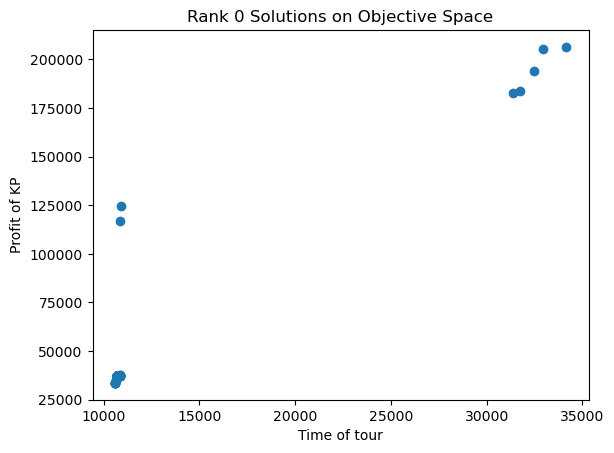

In [16]:
plt.scatter(x1, -y1)
plt.xlabel("Time of tour")
plt.ylabel("Profit of KP")
plt.title('Rank 0 Solutions on Objective Space')

Text(0.5, 1.0, 'Rank 0 Solutions on Objective Space')

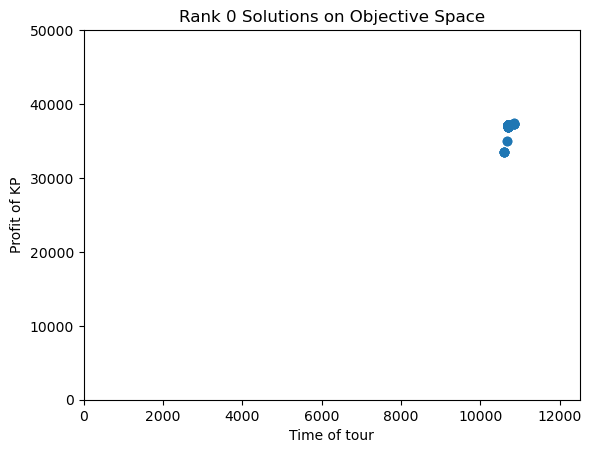

In [17]:
plt.scatter(x1, -y1)
plt.xlim(0,12500)
plt.ylim(0,50000)
plt.xlabel("Time of tour")
plt.ylabel("Profit of KP")
plt.title('Rank 0 Solutions on Objective Space')

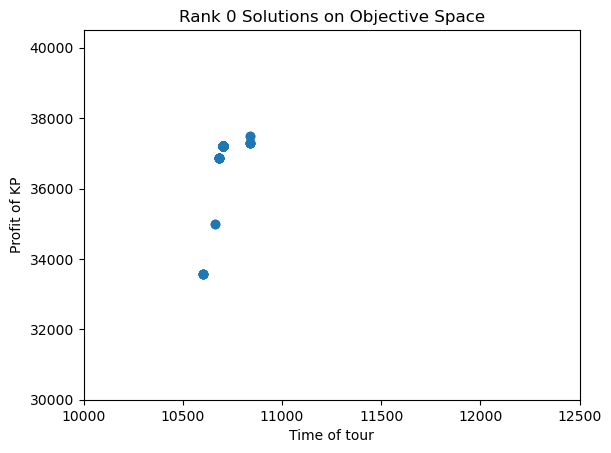

In [18]:
plt.scatter(x1, -y1)
plt.xlim(10000,12500)
plt.ylim(30000,40500)
plt.xlabel("Time of tour")
plt.ylabel("Profit of KP")
plt.title('Rank 0 Solutions on Objective Space');

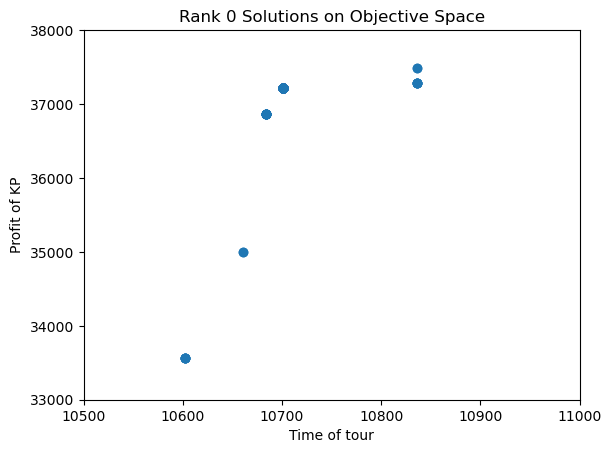

In [19]:
plt.scatter(x1, -y1)
plt.xlim(10500,11000)
plt.ylim(33000, 38000)
plt.xlabel("Time of tour")
plt.ylabel("Profit of KP")
plt.title('Rank 0 Solutions on Objective Space');

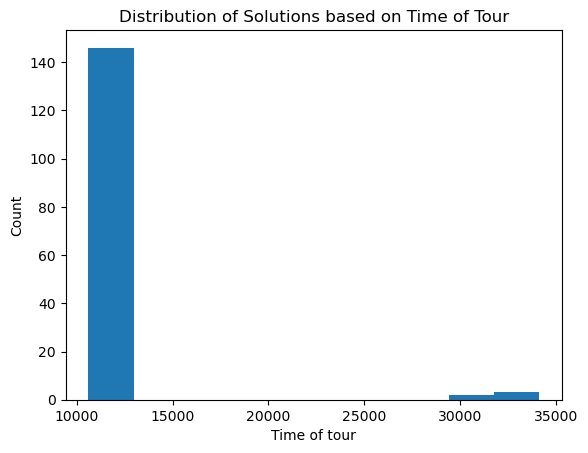

In [20]:
plt.hist(x1)
plt.xlabel("Time of tour")
plt.ylabel("Count")
plt.title('Distribution of Solutions based on Time of Tour');

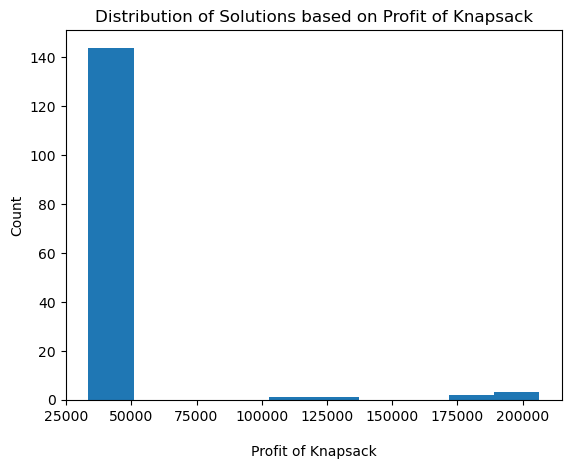

In [21]:
plt.hist(-y1)
plt.xlabel("\nProfit of Knapsack")
plt.ylabel("Count")
plt.title('Distribution of Solutions based on Profit of Knapsack');

In [22]:
results = pd.DataFrame({'time':x1, 'profit':-y1})

In [30]:
results = results.sort_values(by=['time','profit'])[:100]

#### Results of JoMar

In [26]:
# Read the data from the text file
jomar_answer = np.loadtxt('./jomar_a280_n279.txt')

In [29]:
len(jomar_answer)

100

In [31]:
len(results)

100

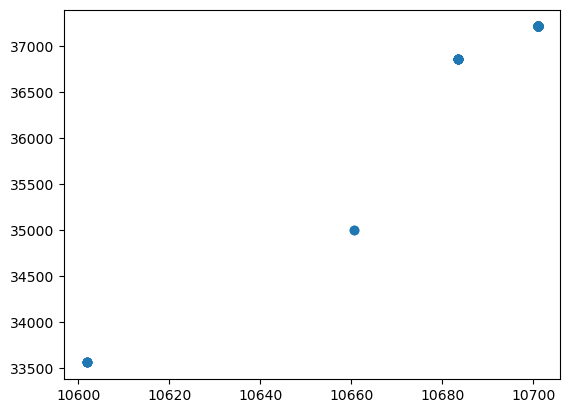

In [37]:
plt.scatter(results['time'], results['profit'])

In [42]:
jomar_df = pd.DataFrame(jomar_answer, columns=['time','profit'])

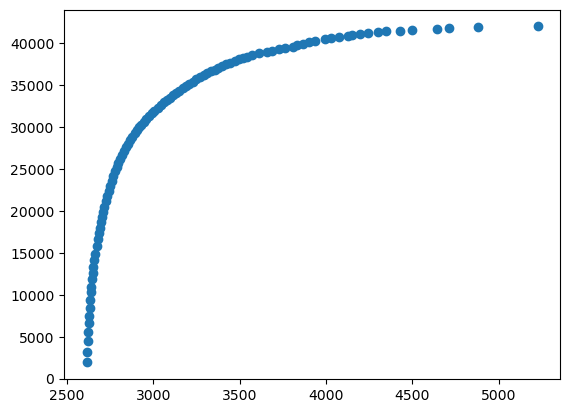

In [45]:
plt.scatter(jomar_df['time'], jomar_df['profit'])

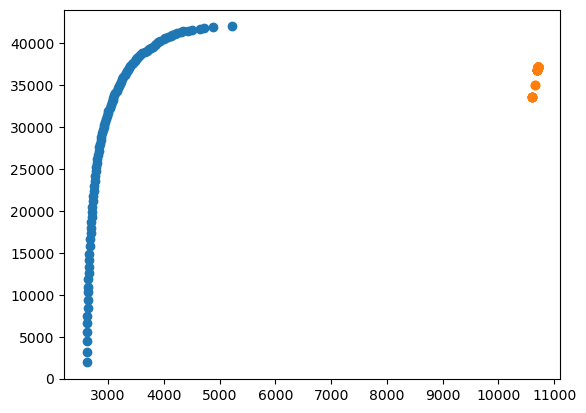

In [44]:
plt.scatter(jomar_df['time'], jomar_df['profit'])
plt.scatter(results['time'], results['profit'])